In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot  as plt
import torch
from medseg.common_utils.basic_operations import load_img_label_from_path,crop_or_pad,rescale_intensity
from medseg.models.model_util import makeVariable
from medseg.models.advanced_triplet_recon_segmentation_model_3 import AdvancedTripletReconSegmentationModel_3
from medseg.common_utils.vis import plot_image,plot_general
from medseg.dataset_loader.dataset_utils import normalize_minmax_data

In [2]:
def show_img(res):
    plt.imshow(res, cmap ='gray')
    plt.show()

In [5]:
path = "/data1/zfx/data/BileDuct/preprocessed_data/BileDuct_012.npy"
data = np.load(path)
index = 90
image, label = data[0][index][4], data[-1][index][4]

In [31]:
# normalize
image = np.squeeze(normalize_minmax_data(image[np.newaxis,:,:]))

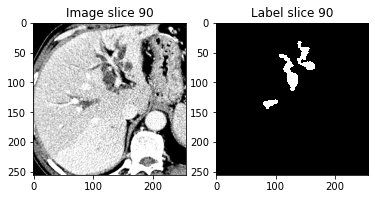

In [32]:
slice_id = index
plt.subplot(121)
plt.title(f'Image slice {slice_id}')
plt.imshow(image,cmap='gray')
plt.subplot(122)
plt.title(f'Label slice {slice_id}')
plt.imshow(label,cmap='gray',interpolation='nearest')

In [33]:
## here we load the model trained w/ standard training
checkpoint_dir = '/data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints'
segmentation_model = AdvancedTripletReconSegmentationModel_3(network_type = 'FCN_16_standard',image_ch=1,
                                                          checkpoint_dir=checkpoint_dir,
                                                          num_classes=2,use_gpu=True,debug=False)


segmentation_model.eval()

construct FCN_16_standard
load saved params from /data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints/image_encoder.pth
load saved params from /data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints/shape_decoder.pth
load saved params from /data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints/shape_encoder.pth
load saved params from /data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints/segmentation_decoder.pth
load saved params from /data1/zfx/code/latentAugmentation/medseg/saved/train_BileDuct_10_n_cls_2/BileDuct/cooperative_training/2/model/best/checkpoints/image_decoder.pth
set optimizer for: image_encoder
set optimizer for: segmentation_decoder
set optimizer for: shape_encoder
set optimiz

In [34]:
imageV = makeVariable(torch.from_numpy(image[np.newaxis,np.newaxis,:,:]),type='float',requires_grad=False,use_gpu=True)
labelV = makeVariable(torch.from_numpy(label),type='long',requires_grad=False,use_gpu=True)

In [35]:
predict = segmentation_model.predict(imageV, softmax=False)

In [36]:
np.unique(predict.max(1)[1].cpu().numpy())

array([0, 1])

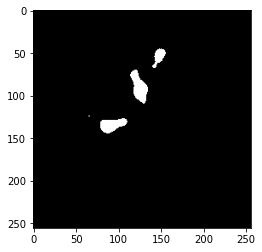

In [37]:
show_img(predict.max(1)[1].cpu().numpy()[0])

In [38]:
(z_i,z_s), initial_predict = segmentation_model.fast_predict(imageV)

In [39]:

def gen_corrupted_image(segmentation_model, latent_code, reference_image,method='channel', max_threshold=0.5,soft_masking=True,random_threshold=True,eval=False):
    assert max_threshold>=0 and max_threshold<=1, f'max_threshold {max_threshold} must be in [0,1]' 
    if max_threshold>0:
        perturbed_z_i_0,mask = segmentation_model.perturb_latent_code(latent_code =latent_code,
                                                                    label_y=reference_image,perturb_type=method,
                                                                    decoder_function = segmentation_model.model['image_decoder'],
                                                                    loss_type= 'mse',
                                                                    if_soft=soft_masking,
                                                                    threshold=max_threshold,random_threshold=random_threshold)
        perturbed_image_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                    latent_code = perturbed_z_i_0,eval=eval,disable_track_bn_stats=True)
    else:
        perturbed_image_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                latent_code = latent_code,eval=eval,disable_track_bn_stats=True)
        mask = torch.ones_like(latent_code,device=latent_code.device, dtype = latent_code.dtype,requires_grad=False)
        perturbed_z_i_0 = latent_code
    return perturbed_image_0, perturbed_z_i_0,mask

## Note: here, we use a fixed threhold each time for ease of comparison
thresholds =[0, 0.1,0.2,0.3,0.4,0.5]
random_threshold = False
methods = ['dropout','channel','spatial'] ## 'channel', 'spatial' are targeted masking methods.
soft_masking = True ## for targeted masking.
results = {}

for i, method in enumerate(methods):
    results[method] ={}
    for j,threshold in enumerate(thresholds):
        corrupted_img, masked_z, mask = gen_corrupted_image(segmentation_model,latent_code=z_i,reference_image=imageV,
                                                method=method,soft_masking=soft_masking,max_threshold=threshold, random_threshold=random_threshold)
        results[method][threshold] = [corrupted_img, masked_z, mask]



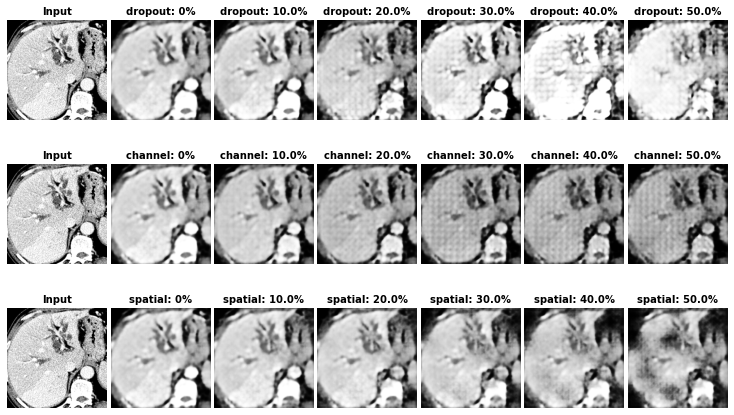

In [40]:
# visualization
fig,axes = plt.subplots(len(methods),1+len(thresholds),figsize=(10,6))
font_size = 10
slice_id = index
for i,method in enumerate(methods):
    plot_image(image,ax = axes[i,0], title = 'Input',font_size=font_size)
    for j,threshold in enumerate(thresholds):
        result = results[method][threshold]
        subtitle = f'{method}: {threshold*100}%'
        # print(result[0].shape)
        plot_image(result[0].detach().cpu().numpy()[0][0],ax = axes[i,j+1], title =subtitle,font_size=font_size)

# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.04, hspace=0)


In [42]:
labelV = data[-1][index][4]
labelV = makeVariable(torch.from_numpy(labelV).unsqueeze(0),type='long',requires_grad=False,use_gpu=True)

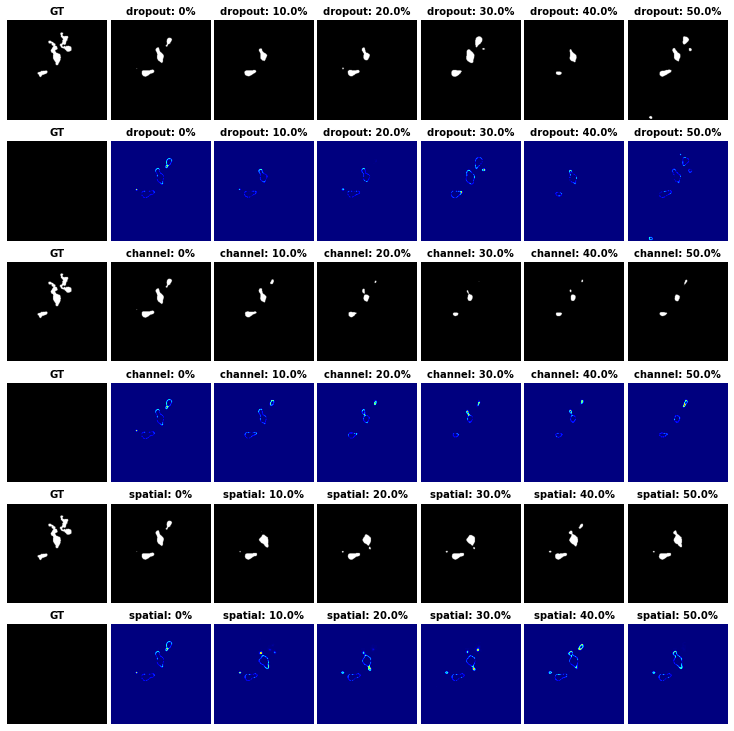

In [43]:
## corrupted shape
from medseg.common_utils.uncertainty import cal_batch_entropy_maps
def gen_corrupted_segmentation(segmentation_model, latent_code, reference_segmentation,method='channel', max_threshold=0.5,soft_masking=True,random_threshold=True,eval=False):
    assert max_threshold>=0 and max_threshold<=1, f'max_threshold {max_threshold} must be in [0,1]' 
    if max_threshold>0:
        perturbed_z_s_0,mask = segmentation_model.perturb_latent_code(latent_code =latent_code,
                                                                    label_y=reference_segmentation,perturb_type=method,
                                                                    decoder_function = segmentation_model.model['segmentation_decoder'],
                                                                    loss_type= 'ce', 
                                                                    if_soft=soft_masking,
                                                                    threshold=max_threshold,random_threshold=random_threshold,
                                                                    ) 
        perturbed_segmentation_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['segmentation_decoder'],
                                                                    latent_code = perturbed_z_s_0,eval=eval,disable_track_bn_stats=True)
    else:
        perturbed_segmentation_0 =segmentation_model.decoder_inference(decoder =segmentation_model.model['segmentation_decoder'],
                                                                latent_code = latent_code,eval=eval,disable_track_bn_stats=True)
        mask = torch.ones_like(latent_code,device=latent_code.device, dtype = latent_code.dtype,requires_grad=False)
        perturbed_z_s_0 = latent_code
    return perturbed_segmentation_0, perturbed_z_s_0,mask

## Note: here, we use a fixed threhold each time for ease of comparison
thresholds =[0, 0.1,0.2,0.3,0.4,0.5]
methods = ['dropout','channel','spatial'] ## 'channel', 'spatial' are targeted masking methods.
soft_masking = True ## for targeted masking.
results = {}

for i, method in enumerate(methods):
    results[method] ={}
    for j,threshold in enumerate(thresholds):
        corrupted_seg, masked_z, mask = gen_corrupted_segmentation(segmentation_model,latent_code=z_s,reference_segmentation=labelV,
                                                method=method,soft_masking=soft_masking,max_threshold=threshold, random_threshold=random_threshold)
        ## soft FTN's prediction.
        soft_max_prob = torch.nn.functional.softmax(corrupted_seg/2.0,dim=1)
        results[method][threshold] = [corrupted_seg.max(1)[1],soft_max_prob, masked_z, mask]
# visualization
fig,axes = plt.subplots(len(methods)*2,1+len(thresholds),figsize=(10,10))
font_size = 10
slice_id =4
for i,method in enumerate(methods):
    plot_general(label,ax =axes[2*i,0], title = 'GT',font_size=font_size,cmap ='gray')
    plot_general(label*0,ax =axes[2*i+1,0], title = 'GT',font_size=font_size,cmap ='gray')

    for j,threshold in enumerate(thresholds):
        result = results[method][threshold]
        subtitle = f'{method}: {threshold*100}%'
        pred_hard_map =result[0].detach().cpu().numpy()
        entropy_map  = cal_batch_entropy_maps(result[1].detach().cpu().numpy())
        # print(pred_hard_map.shape)
        plot_general(pred_hard_map[0],ax = axes[2*i,j+1], title =subtitle,font_size=font_size)
        plot_general(entropy_map[0],ax = axes[2*i+1,j+1], title =subtitle,font_size=font_size,cmap ='jet')

# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.04, hspace=0.04)
